In [84]:
!pip install shapely[vectorized]

     |################################| 1.5MB 1.1MB/s eta 0:00:01    |                                | 30kB 724kB/s eta 0:00:02     |################                | 768kB 1.1MB/s eta 0:00:01     |##########################      | 1.2MB 1.1MB/s eta 0:00:01


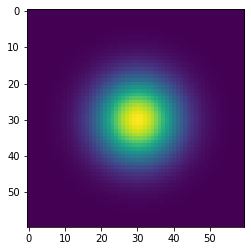

In [140]:
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import multivariate_normal

sigma = 10
spread = 3
extent = int(spread * sigma)

# norm = multivariate_normal(mean=(extent, extent), cov=(60, 60))

# x = np.linspace(0, 3, 3)
# y = np.linspace(0, 3, 3)
# xxyy = np.c_[x, y]
# xxyy

heatmap = np.zeros([2 * extent, 2 * extent], dtype=np.float32)
for i in range(2 * extent):
    for j in range(2 * extent):
        heatmap[i, j] = (
            1
            / 2
            / np.pi
            / (sigma ** 2)
            * np.exp(
                -1
                / 2
                * ((i - spread * sigma - 0.5) ** 2 + (j - spread * sigma - 0.5) ** 2)
                / (sigma ** 2)
            )
        )

plt.imshow(heatmap)
plt.show()

# sigma = 10

# 1 / 2 / np.pi / (sigma ** 2), 1 / (2 * np.pi * sigma ** 2)
# 1 / 2 / 3 == 1 / (2 * 3)
# 3 * 4 ** 2 == 3 * (4 ** 2)

In [95]:
import torch
import torch.nn.functional as F 

a = torch.rand(1, 1, 4, 4)
b = torch.rand(1, 1, 4, 4)
loss = F.mse_loss(a, b, reduction="none")

# loss.shape

torch.Size([1, 1, 4, 4])

[[ 0.  0.]
 [63.  0.]
 [63. 63.]
 [ 0. 63.]]


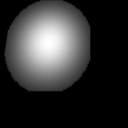

In [57]:
import numpy as np
from PIL import Image, ImageDraw

import cv2


w, h = 64, 64
center = w // 2
sigma = 18.5

gaussian_heatmap = np.zeros([w, h], dtype=np.float32)
for i_ in range(w):
    for j_ in range(h):
        gaussian_heatmap[i_, j_] = 1 / 2 / np.pi / (sigma ** 2) * np.exp(-1 / 2 * ((i_ - center) ** 2 + (j_ - center) ** 2) / (sigma ** 2))

gaussian_heatmap = (gaussian_heatmap / np.max(gaussian_heatmap) * 255).astype(np.uint8)
# gaussian_heatmap = np.clip(gaussian_heatmap, 20, 255)
gaussian_heatmap[gaussian_heatmap < 50] = 0


# im = Image.new("L", (64, 64))


# transformed = four_point_transform(heatmap, bbox.astype(np.float32), [image.shape[0], image.shape[1]])
# image = np.maximum(image, transformed)


def warp(image, pts=[[20, 10], [80, 10], [80, 80], [10, 80]], size=(128, 128)):
    height, width = size

    center_pt = np.mean(pts, axis=0)
    pts = pts - center_pt[None, :]
#     pts = pts*center/config.threshold_point
    pts = pts*center/25
    pts = pts + center_pt[None, :]

    src = np.array([
        [0, 0],
        [image.shape[1] - 1, 0],
        [image.shape[1] - 1, image.shape[0] - 1],
        [0, image.shape[0] - 1]], dtype="float32")
    dst = np.array(pts, dtype=np.float32)
    print(src)
    return cv2.warpPerspective(image, cv2.getPerspectiveTransform(src, dst), (width, height))

# im
# gaussian_heatmap
# im = Image.fromarray(np.uint8(gaussian_heatmap))
# np.array(im).shape

# Image.fromarray(warp(gaussian_heatmap))
im = warp(gaussian_heatmap)
# im.shape

Image.fromarray(im)

# image = gaussian_heatmap

# src = np.array([[0,0],[0, 0],[70,420],[420,70]],np.float32)
# dst = np.array([[0,0],[299,299],[0,299],[299,0]],np.float32)
# trans = cv2.getPerspectiveTransform(src,dst)
# trans

# cv2.warpPerspective(image, cv2.getPerspectiveTransform(src, dst), (width, height))
# transformed = image.transform(
#     image.size, Image.PERSPECTIVE,
#     [
#         a0, a1, a2, 
#         a3, a4, a5,
#         a6, a7
#     ],
#     Image.BILINEAR
# )



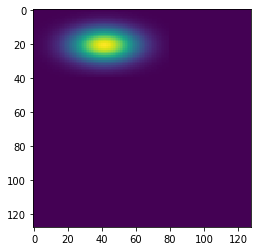

In [92]:
import matplotlib.pyplot as plt

import numpy as np
import cv2
from shapely.geometry import Polygon


def four_point_transform(image, pts):
    max_x, max_y = (
        np.max(pts[:, 0]).astype(np.int32),
        np.max(pts[:, 1]).astype(np.int32),
    )

    dst = np.array(
        [
            [0, 0],
            [image.shape[1] - 1, 0],
            [image.shape[1] - 1, image.shape[0] - 1],
            [0, image.shape[0] - 1],
        ],
        dtype="float32",
    )

    M = cv2.getPerspectiveTransform(dst, pts)
    warped = cv2.warpPerspective(image, M, (max_x, max_y))

    return warped

class DataLoader():
    def __init__(self):
        sigma = 10
        spread = 3
        extent = int(spread * sigma)
        self.gaussian_heatmap = np.zeros([2 * extent, 2 * extent], dtype=np.float32)

        for i in range(2 * extent):
            for j in range(2 * extent):
                self.gaussian_heatmap[i, j] = (
                    1
                    / 2
                    / np.pi
                    / (sigma ** 2)
                    * np.exp(
                        -1
                        / 2
                        * (
                            (i - spread * sigma - 0.5) ** 2
                            + (j - spread * sigma - 0.5) ** 2
                        )
                        / (sigma ** 2)
                    )
                )

        self.gaussian_heatmap = (
            self.gaussian_heatmap / np.max(self.gaussian_heatmap) * 255
        ).astype(np.uint8)

    def add_character(self, image, bbox):

        if not Polygon(bbox.reshape([4, 2]).astype(np.int32)).is_valid:
            return image
        top_left = np.array([np.min(bbox[:, 0]), np.min(bbox[:, 1])]).astype(np.int32)
        if top_left[1] > image.shape[0] or top_left[0] > image.shape[1]:
            # This means there is some bug in the character bbox
            # Will have to look into more depth to understand this
            return image
        bbox -= top_left[None, :]
        transformed = four_point_transform(
            self.gaussian_heatmap.copy(), bbox.astype(np.float32)
        )

        start_row = max(top_left[1], 0) - top_left[1]
        start_col = max(top_left[0], 0) - top_left[0]
        end_row = min(top_left[1] + transformed.shape[0], image.shape[0])
        end_col = min(top_left[0] + transformed.shape[1], image.shape[1])

        image[
            max(top_left[1], 0) : end_row, max(top_left[0], 0) : end_col
        ] += transformed[
            start_row : end_row - top_left[1], start_col : end_col - top_left[0]
        ]

        return image

    def generate_target(self, image_size, character_bbox):
#         character_bbox = character_bbox.transpose(2, 1, 0)
        channel, height, width = image_size

        target = np.zeros([height, width], dtype=np.uint8)

        for i in range(character_bbox.shape[0]):
            target = self.add_character(target, character_bbox[i])

        return target / 255, np.float32(target != 0)
    
d = DataLoader()
x, mask = d.generate_target((1, 128, 128), np.array([[[0, 0], [80, 0], [80, 40], [0, 40]]]))
plt.imshow(x)
plt.show()

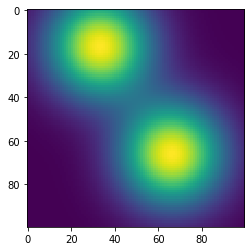

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# create 2 kernels
m1 = (-1,-2)
s1 = np.eye(2)
k1 = multivariate_normal(mean=m1, cov=s1)

m2 = (1,1)
s2 = np.eye(2)
k2 = multivariate_normal(mean=m2, cov=s2)

# create a grid of (x,y) coordinates at which to evaluate the kernels
xlim = (-3, 3)
ylim = (-3, 3)
xres = 100
yres = 100

x = np.linspace(xlim[0], xlim[1], xres)
y = np.linspace(ylim[0], ylim[1], yres)
xx, yy = np.meshgrid(x,y)

# evaluate kernels at grid points
xxyy = np.c_[xx.ravel(), yy.ravel()]
zz = k1.pdf(xxyy) + k2.pdf(xxyy)
# k1.pdf(xxyy[0])


# # reshape and plot image
img = zz.reshape((xres,yres))
plt.imshow(img)
plt.show()